# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Описание данных

В папке path содержится csv-файл labels.csv с двумя колонками file_name и real_age и папка с изображениями /final_files

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

In [2]:
PATH = '/datasets/faces/'

In [3]:
data_ages = pd.read_csv(PATH + 'labels.csv')

In [4]:
data_ages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [18]:
data_ages.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [19]:
data_ages.tail()

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [6]:
data_ages.isna().sum()

file_name    0
real_age     0
dtype: int64

In [7]:
data_ages.shape

(7591, 2)

In [8]:
 data_ages.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [9]:
 data_ages.duplicated().sum()

0

In [10]:
f'число уникальных возрастов {len(data_ages.real_age.unique())}'

'число уникальных возрастов 97'

In [11]:
data_ages.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


посмотрим на распределение по возрастам

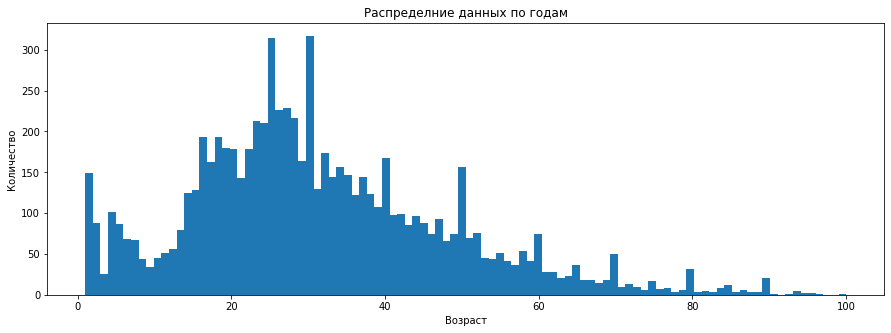

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist(data_ages.real_age, bins=100);
ax.set_title('Распределние данных по годам');
ax.set(xlabel='Возраст', ylabel='Количество');

график смещен в право, есть всплески по "круглым возрастам", это может говорить о том, что некоторые данные были внесены руками (примерно, на вид)

посмотрим на изображения и их размерность

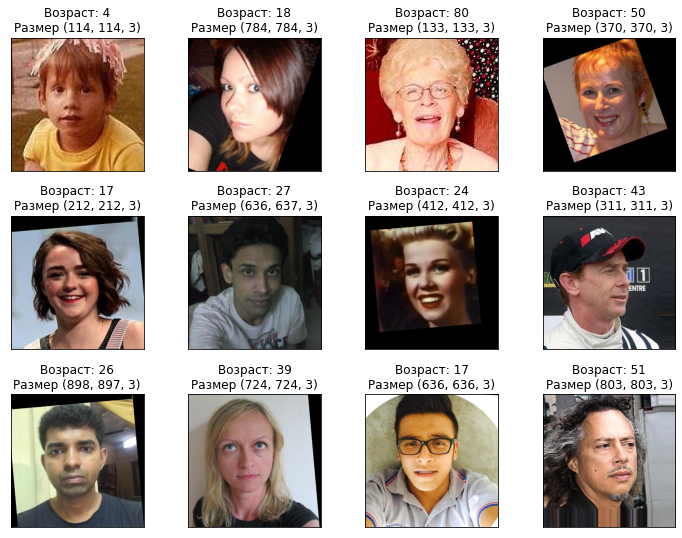

In [13]:
fig = plt.figure(figsize=(10, 10))

for i in range(12):
    
    img_name, age = data_ages.loc[i]
    image = Image.open('/datasets/faces/final_files/' + img_name)
    #plt.axis('off')
    np_img = np.array(image)
    fig.add_subplot(4, 4, i+1).set_title(
        'Возраст: {0}{1}Размер {2}'.format(str(age), '\n', np_img.shape ))
    plt.xticks([])
    plt.yticks([])    
    plt.imshow(np_img)
    plt.tight_layout()
    #fig.suptitle(title, fontsize=15)

plt.show()

картинки уже покручены и меют разные размеры

Краткий вывод:

* в ходе работы над разделом было установленно, что датасет содержит 7591 строку
* не содержит явных дубликатов и пропусков
* медиана находится на отметке в 29 лет
* среднее значение примерно 31,2 года
* имеются всплески в районе 25, 30, 40, 50, 60, 70, 80, 90 это может говорить о том, что некоторые данные были внесены руками (примерно, на вид) 
* картинки покручены, имеют разную размерность, но цветовая схема у всех одинаковая
* число уникальных возрастов равно 97

## Обучение модели

Модель будет обучатся с использованием сервера Tesla V100-SXM2-32GB параметры:
* расчетная мощность: 7.0
* частота процессора: 1.53GHz
* обьем оперативной памяти: 31.75GiB
* пропускная способность памяти устройства: 836.37GiB/s

расчет производится на мощностях с использованием GPU
 

```python

"""
   file to send to the server
"""
# imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D,
                                     )

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_data(path: str, train: bool = False) -> iter:
    """
    generating samples from a dataset for training
    and checking the quality of model training

    Args:
        path (str): path to the root directory with images and csv file
        train (bool, optional): to separate the test and training samples.
        Defaults to False (generate training sample).

    Returns:
        DataFrameIterator
    """
    data_ages = pd.read_csv(path + 'labels.csv')
    # data_ages.drop_duplicates(inplace=True)
    datagen = ImageDataGenerator(validation_split=0.25,
                                 # vertical_flip=train,
                                 horizontal_flip=train,
                                 # rotation_range=45 if train else 0,
                                 rescale=1./255)

    data = datagen.flow_from_dataframe(
        dataframe=data_ages,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=15,
        class_mode='raw',
        subset='training' if train else 'validation',
        seed=12345
        )
    return data


def load_train(path: str) -> iter:
    """
    generating training sample from a dataset
    Args:
        path (str): path to the root directory with images and csv file

    Returns:
        DataFrameIterator
    """
    return load_data(path, train=True)


def load_test(path: str) -> iter:
    """
    generating train sample from a dataset
    Args:
        path (str): path to the root directory with images and csv file

    Returns:
        DataFrameIterator
    """
    return load_data(path, train=False)


def create_model(input_shape: tuple, lr: float = 1e-4) -> Sequential:
    """
    creating a training model

    Args:
        input_shape (tuple): shape datasets
        lr (float, optional): floating point value learning rate.
            Defaults to 1e-4.

    Returns:
        Sequential: training model
    """
    model = Sequential()

    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)

    # не замораживаем слои ResNet50
    backbone.trainable = True
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size: int = None, epochs: int = 6,
                steps_per_epoch: int = None, validation_steps: int = None):
    """_summary_

    Args:
        model (Sequential): train model
        train_data (iter): data for model training
        test_data (iter): data for model testing
        batch_size (int, optional): batch size. Defaults to None.
        epochs (int, optional): count epochs. Defaults to 6.
        steps_per_epoch (int, optional): number of steps per epoch.
            Defaults to None.
        validation_steps (int, optional): number of steps validation.
            Defaults to None.

    Returns:
        Sequential: trained model
    """
    if not steps_per_epoch:
        steps_per_epoch = len(train_data)
    if not validation_steps:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

# for local testing
# if __name__ == "__main__":
#     train_data = load_train('/home/oslik/test_jpg/datasets/faces/')
#     test_data = load_train('/home/oslik/test_jpg/datasets/faces/')
#     model = create_model((150, 150, 3), lr=1)
#     print(
#         train_model(
#             model,
#             train_data=train_data,
#             test_data=test_data,
#             epochs=1
#             )
#         )

```

<pre>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================

Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


</pre>

Train for 356 steps, validate for 119 steps

Epoch 1/8
380/380 - 48s - loss: 218.0081 - mae: 10.6287 - val_loss: 648.4815 - val_mae: 20.2946

Epoch 2/6
380/380 - 39s - loss: 85.7651 - mae: 7.1153 - val_loss: 114.7910 - val_mae: 8.1687

Epoch 3/6
380/380 - 38s - loss: 57.5429 - mae: 5.8100 - val_loss: 81.3813 - val_mae: 6.7181

Epoch 4/6
380/380 - 38s - loss: 44.8881 - mae: 5.1233 - val_loss: 77.5937 - val_mae: 6.6238

Epoch 5/6
380/380 - 39s - loss: 34.4057 - mae: 4.5054 - val_loss: 71.3283 - val_mae: 6.4673

Epoch 6/6
380/380 - 44s - loss: 25.2132 - mae: 3.8485 - val_loss: 73.1489 - val_mae: 6.2157



127/127 - 10s - loss: 73.1489 - mae: 6.2157

Test MAE: 6.2157

## Анализ обученной модели

В рамках текущего проекта были проведены следующие работы:

1. Проведен предварительный анализ данных. 

в ходе этапа:
* определен размер датасета (7591 строка)
* датасет проверен на содержание явных дубликатов и пропусков
* определены медианное и среднее значение 29 и 31,2 года соответственно
* построен график распределения возростов (распределение нормальное со скосом вправо.)
* обнаружены всплески в районе 25, 30, 40, 50, 60, 70, 80, 90 это может говорить о том, что некоторые данные были внесены руками (примерно, на вид)
* исходные изображения имеют вращения и разную размерность, но цветовая схема у всех одинаковая
* число уникальных значений возрастов - 97

Вывод по этапу предварительного анализа: данные корректные.

2. Обучена свёрточная нейронная сеть на базе архитектуры ResNet50 и решена задача регрессии.

* Для обучения использовано 75% данных
* Модель обучалась использованием сервера Tesla V100-SXM2-32GB с параметрами:
 * * расчетная мощность: 7.0
 * * частота процессора: 1.53GHz
 * * обьем оперативной памяти: 31.75GiB
 * * пропускная способность памяти устройства: 836.37GiB/s
 * * расчет производится на мощностях с использованием GPU
 
* Обучение произведено на 8-и эпохах. после 6 эпохи сильного прироста в качестве нет
* при этом видно что между 3-й и 6-й эпохами сильного прироста в качестве уже нет и модель начинает сильно переобучаться
* Значение заданной метрики MAE - 6.2157 

Вывод
Модель в среднем ошибается на 6,2 лет, по условиям задачи МАЕ не должен привышать 8. цель достигнута